In [16]:
import pandas as pd
import ast
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
data=pd.read_csv('Hotel_Reviews.csv') #read the csv file

In [ ]:
# Preparing data for analysis
# This cell is a bit slow to run, so it is intended to be run only once

# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# Label encode non-numerical features

label_encoded_hotel_address = LabelEncoder()
data['Hotel_Address'] = label_encoded_hotel_address.fit_transform(data['Hotel_Address'])

label_encoded_hotel_name = LabelEncoder()
data['Hotel_Name'] = label_encoded_hotel_address.fit_transform(data['Hotel_Name'])

label_encoded_reviwer_nationality = LabelEncoder()
data['Reviewer_Nationality'] = label_encoded_reviwer_nationality.fit_transform(data['Reviewer_Nationality'])

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sindr\AppData\Local\Temp\ipykernel_11044\3923831437.py:19: SyntaxWarning: invalid escape sequence '\d'
  data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
C:\Users\sindr\AppData\Local\Temp\ipykernel_11044\3923831437.py:20: SyntaxWarning: invalid escape sequence '\d'
  data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int


### Plot of correlation matrix in order to see which features can be dropped.

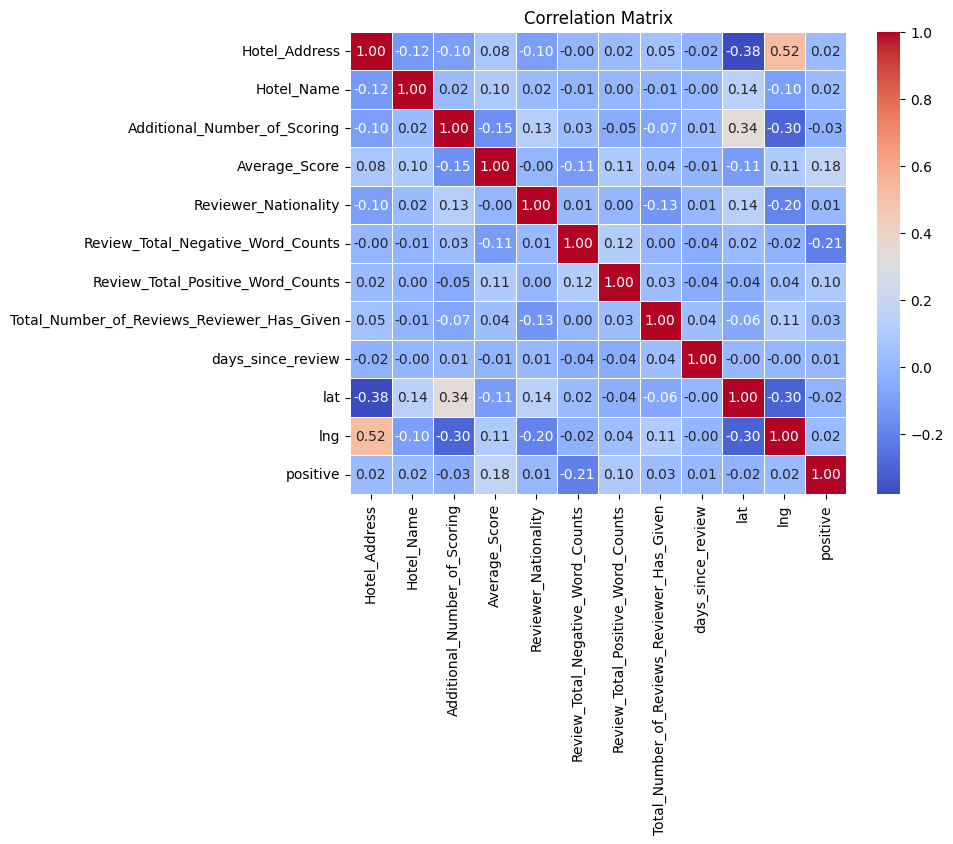

In [53]:
# binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data['positive'] = (data['Reviewer_Score'] >= 5).astype(int)

numerical_data = data[['Hotel_Address', 'Hotel_Name','Additional_Number_of_Scoring', 'Average_Score', 'Reviewer_Nationality', 'Review_Total_Negative_Word_Counts',
                            'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',
                            'days_since_review', 'lat', 'lng', 'positive']]

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap (ChatGPT)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment. 

In [ ]:
# Dropping irrelevant features
data.drop('Hotel_Address',axis=1,inplace=True)  
data.drop('Hotel_Name',axis=1,inplace=True)  
data.drop('Review_Date',axis=1,inplace=True)    
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  
data.drop('lat',axis=1,inplace=True)    
data.drop('lng',axis=1,inplace=True)    
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)   
data.drop('Total_Number_of_Reviews_Reviewer_Has_Given',axis=1,inplace=True)
data.drop('days_since_review',axis=1,inplace=True)  
data.drop('Reviewer_Nationality',axis=1,inplace=True)  

# LSTM model

## How it works

The memory cell is controlled by three gates
- Input gate - controls information added to the cell
- Forget gate - Determines what information is removed from the cell
- Output gate - Controls information is output from the 

The memory cell allows the model to retain long-term dependencies.

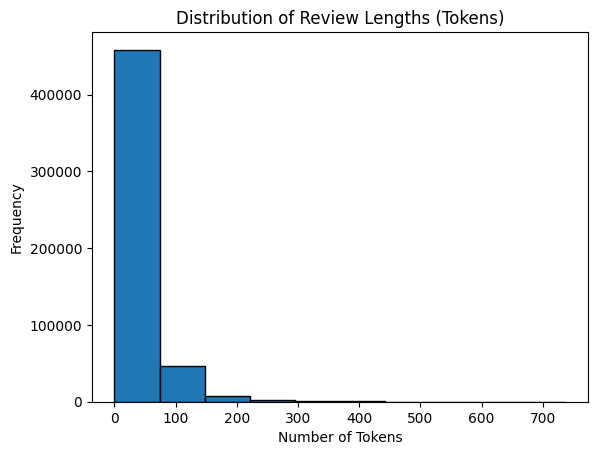

Max review length: 737
Min review length: 0
Average review length: 36.31590846515091
95th percentile review length: 106.0


Total number of unique words: 84122
max_vocab for 97.5% coverage: 5018 words


In [ ]:
# Denne cellen kan ignoreres. Brukes bare til å finne verdier for MAX_LEN og MAX_VOCAB

df = data.copy()

review_lengths = df["Review_Total_Negative_Word_Counts"] + df["Review_Total_Positive_Word_Counts"]

reviews = df["Negative_Review"] + df["Positive_Review"]

# tokenize the reviews and create a list of all words
all_words = [word for review in reviews for word in review.lower().split()]

# count the frequency of each word
word_counts = Counter(all_words)

# cumulative sum of word frequencies
sorted_word_counts = sorted(word_counts.values(), reverse=True)
cumulative_sum = np.cumsum(sorted_word_counts)
total_words = sum(sorted_word_counts)

# Find unique words by converting the list of tokens to a set
unique_words = set(all_words)


# plot the distribution of review lengths (number of tokens)
plt.hist(review_lengths, bins=10, edgecolor='black')
plt.title('Distribution of Review Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# printing relevant information
print(f"Max review length: {max(review_lengths)}")
print(f"Min review length: {min(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths)}")
print(f"95th percentile review length: {np.percentile(review_lengths, 95)}")
print("\n")
print(f"Total number of unique words: {len(unique_words)}")

# finding ideal MAX_VOCAB 

desired_coverage = 97.5

for max_vocab in range(1, len(cumulative_sum) + 1):

    coverage = cumulative_sum[max_vocab - 1]  
    coverage_percentage = (coverage / total_words) * 100
    
    if coverage_percentage >= desired_coverage:
        print(f"max_vocab for {desired_coverage}% coverage: {max_vocab} words")
        break 


# LSTM model

## How the model works


## Target
To determine sentiment, a target variable "positive" is created. The target is 1 if reviewer_score >= 5, otherwise 0. The threshold is set to 5, as it seems like the natural tipping point between a positive and negative review. Setting the threshold to 5 leads to a high level of imbalance in the target variable, which is why stratify=y when splitting.

## Tokenizing and padding
When tokenizing, we set a limit for how many unique words should be included. This means that only the MAX_VOCAB (5018) most used words will be included. The limit is set such that the words included cover 97.5% of all words in the dataset. In this case, the value used is roughly 6% of the amount of unique words. This indicated that most reviews include mostly the same words.

When padding, the max_len is set such that it covers 95% of all reviews. 

## Encoding
Labelencoding is used because it is less memory intensive than one hot encoding.

# Data preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))

data_lstm = data.copy()

# binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data_lstm['positive'] = (data_lstm['Reviewer_Score'] >= 5).astype(int)

# text preprocessing
MAX_VOCAB = 5018 # 97.5% coverage
MAX_LEN = 106 # 95th percentile of tokens in review

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].astype(str)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].astype(str)

# this function was made by ChatGPT
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].apply(remove_stopwords)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].apply(remove_stopwords)

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(data_lstm['Positive_Review'] + data_lstm['Negative_Review'])

# text to sequences
X_pos = tok.texts_to_sequences(data_lstm['Positive_Review'])
X_neg = tok.texts_to_sequences(data_lstm['Negative_Review'])

# pad sequences
X_pos = pad_sequences(X_pos, maxlen=MAX_LEN, padding='post', truncating='post')
X_neg = pad_sequences(X_neg, maxlen=MAX_LEN, padding='post', truncating='post')

# numerical variables
num_variables = ['Average_Score', 'Review_Total_Negative_Word_Counts',
                'Review_Total_Positive_Word_Counts']
scaler = StandardScaler()
X_num = scaler.fit_transform(data_lstm[num_variables])

tags = ['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']

for tag in tags:
    label_encoded_tags = LabelEncoder()
    data_lstm[tag] = label_encoded_tags.fit_transform(data_lstm[tag])  # tag -> integer labels

X_tags = data_lstm[tags].values  # -> NumPy array

# combine features
X = np.hstack((X_pos, X_neg, X_num, X_tags))
y = data_lstm['positive'].values

print(Counter(data_lstm['positive'])) # finding ratio of positive to negative reviews

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = y because of high level of imbalance in positive and negative reviews

Counter({1: 493457, 0: 22281})


## Building the model

In the following cell, we build the model. 

- First LSTM layer: 64 neurons, 
- Second LSTM layer: 32 neurons
- Dense layer: 32 neurons in fully connected layer
- Dropout layer: Randomly drop 20% of inputs during training. Low dropout level, as overfitting is near 0.
- Output layer

Includes performance metrics accuracy and AUC

In [ ]:
# Build the LSTM model
model = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=X_train.shape[1]),
    LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2), # low dropout as overfitting is near 0 anyway
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])


c:\Users\sindr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# Train model
model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/2
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 683s 105ms/step - AUC: 0.7793 - accuracy: 0.9580 - loss: 0.1479 - val_AUC: 0.9425 - val_accuracy: 0.9647 - val_loss: 0.0961
Epoch 2/2
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 645s 100ms/step - AUC: 0.9469 - accuracy: 0.9660 - loss: 0.0915 - val_AUC: 0.9477 - val_accuracy: 0.9660 - val_loss: 0.0920


The model converges quickly, and performance is good regardless of batch size, so only 2-3 epochs needed with batch size = 64 or 128

3224/3224 ━━━━━━━━━━━━━━━━━━━━ 206s 64ms/step


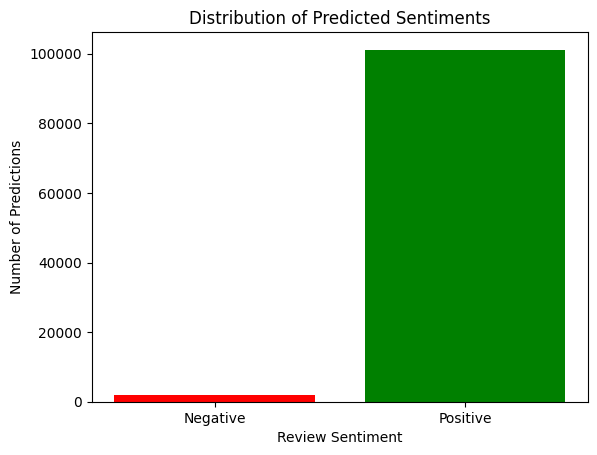

In [ ]:
# Used for plotting the amount of positive and negative reviews predicted by the model

# get probabilies
y_pred_probs = model.predict(X_test)

# convert probabilities to binary labels (positive or negative review)
y_pred = (y_pred_probs >= 0.5).astype(int)

positive_count = np.sum(y_pred == 1)
negative_count = np.sum(y_pred == 0)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Predicted Sentiments")

plt.show()

## Evaluating the model

The following cell is for evaluating the model

The most relevant metrics are accuracy, F1 score and ROC-AUC.

- F1 score is relevant as false positives and false negatives are equally bad.
- ROC-AUC score is relevant as it works well with high imbalances. The score being near 1 also indicates that the model works well across all thresholds.

In [ ]:
# This cell is for evaluating the model

test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
train_loss, train_accuracy, train_auc = model.evaluate(X_train, y_train)
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Train accuracy: {train_accuracy:.2f}')
print(f'Overfitting: {train_accuracy-test_accuracy:.2f}')

# Convert predicted probabilities to binary classification (positive or negative review)
y_pred_prob = model.predict(X_test)  
y_pred = (y_pred_prob >= 0.5).astype(int)  # 1 if probability >= 5, otherwise 0

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob) 

# Results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}') # How many predicted positives are actually positive
print(f'Recall: {recall:.2f}') # How many actual positive cases were correctly predicted
print(f'F1-Score: {f1:.2f}') # Balance betweet precision and recall
print(f'ROC-AUC: {roc_auc:.2f}') # Area under ROC curve (recall against false positive rate)

# Scores from 0-1, where higher scores = better performance

3224/3224 ━━━━━━━━━━━━━━━━━━━━ 170s 53ms/step - AUC: 0.9484 - accuracy: 0.9656 - loss: 0.0934
12894/12894 ━━━━━━━━━━━━━━━━━━━━ 662s 51ms/step - AUC: 0.9595 - accuracy: 0.9675 - loss: 0.0846
Test accuracy: 0.97
Train accuracy: 0.97
Overfitting: 0.00
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 157s 49ms/step
Accuracy: 0.97
Precision: 0.97
Recall: 0.99
F1-Score: 0.98
ROC-AUC: 0.95
